# Black scholes vs Monte Carlo for option pricing

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from matplotlib import pyplot as plt

from black_scholes import black_scholes_call
from monte_carlo import monte_carlo_call

## Black-Scholes Equation for call options



$C(S, t) = N(d_1)S - N(d_2)Ke^{-r(T-t)}$

where:

$d_1 = \frac{\ln(S/K) + \left(r + \frac{\sigma^2}{2}\right)(T - t)}{\sigma \sqrt{T - t}}$

$d_2 = d_1 - \sigma \sqrt{T - t}$


### Variables in the Black-Scholes Equation

- $C(S, t)$: The price of the call option at time $t$, given the stock price $S$.
- $S$: The current price of the underlying stock.
- $K$: The strike price of the option, i.e., the price at which the option can be exercised.
- $T$: The time to maturity of the option, expressed in years.
- $t$: The current time, expressed in years.
- $r$: The risk-free interest rate, assumed to be constant over the life of the option.
- $\sigma$: The volatility of the stock's returns, a measure of how much the stock price fluctuates.
- $N(d_1)$ and $N(d_2)$: The cumulative distribution functions of the standard normal distribution for $d_1$ and $d_2$, representing probabilities.

## Monte Carlo

Black scholes assumes the underlying asset follows a geometric Brownian motion:

\begin{equation*}
dS_t = rS_t dt + \sigma S_t dW_t
\end{equation*}

where:
- $S_t$ is the price of the underlying asset at time $t$
- $r$ is the risk-free interest rate
- $\sigma$ is the volatility of the asset
- $dW_t$ is a Wiener process (or Brownian motion)

Intuitively this means that the price of the asset changes over time due to a predicatble drift and random noise.

### Risk neutral pricing

Assuming no arbitrage there exists a risk neutral measure $\mathbb{Q}$ under which discounted price process is a matingale such that:

\begin{equation*}
C(S_0,K,T) = e^{-rT}\mathbb{E}^\mathbb{Q}[\max(S_T-K, 0)]
\end{equation*}

where:

- $C(S_0,K,T)$: The price of the call option at time $t=0$ with strike price $K$ and maturity $T$.  
- $S_T$: The price of the underlying asset at maturity $T$.  
- $K$: The strike price of the option.  
- $r$: The risk-free interest rate.  
- $\mathbb{E}^\mathbb{Q}$: The expectation under the risk-neutral measure $\mathbb{Q}$.  

- **Risk Neutral Measure ($\mathbb{Q}$):**  
    A probability measure under which the present value of all discounted future cash flows is equal to their current market price. In this measure, all assets are assumed to grow at the risk-free rate, making it easier to price derivatives without considering investors' risk preferences.

- **Martingale:**  
    A stochastic process where the expected value of the next observation, given all past observations, is equal to the current value. Under the risk-neutral measure, the discounted price process of an asset is a martingale, meaning it has no predictable trend other than the risk-free rate.

Under the rick-neutral measure the stock price follows a lognormal distrubution of:

\begin{equation*}
S_t = S_0 \exp{((r - 0.5 \sigma ^ 2)T} + \sigma \sqrt{T} Z)
\end{equation*}

where $Z \sim N(0,1)$

This means we can follow the follwing steps to price an option using a monte carlo approach:

1. sample from $Z$
2. calculate $S^i_T$
3. Calculate the payoff $\max(S^i_T - K, 0)$
4. average over all values of $i$ to get $\mathbb{E}^\mathbb{Q}$
5. multiply by $e^{-rT}$

In [8]:
# initial parameters

S0 = 100  # Current stock price
K = 100   # Strike price
r = 0.05  # Risk-free interest rate (annualized)
sigma = 0.2  # Volatility (annualized)
T = 1  # Time to maturity in years

The Black-Scholes price of the call option is: 10.45058
The Monte Carlo price of the call option is: 10.22323
The percentage difference between Black-Scholes and Monte Carlo prices is: 2.17547%


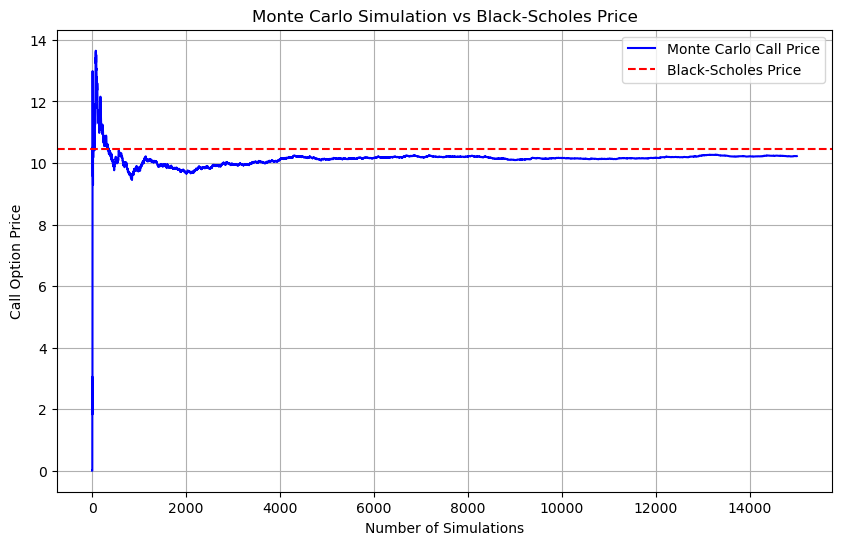

In [9]:
black_scholes_price = black_scholes_call(S0, K, r, sigma, T)
x_values, y_values = monte_carlo_call(S0, K, r, sigma, T)
monte_carlo_price = y_values[-1]
print(f"The Black-Scholes price of the call option is: {black_scholes_price:.5f}")
print(f"The Monte Carlo price of the call option is: {monte_carlo_price:.5f}")

percentage_difference = abs(black_scholes_price - monte_carlo_price) / black_scholes_price * 100
print(f"The percentage difference between Black-Scholes and Monte Carlo prices is: {percentage_difference:.5f}%")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label='Monte Carlo Call Price', color='blue')
plt.axhline(y=black_scholes_price, color='red', linestyle='--', label='Black-Scholes Price')
plt.title('Monte Carlo Simulation vs Black-Scholes Price')
plt.xlabel('Number of Simulations')
plt.ylabel('Call Option Price')
plt.legend()
plt.grid()
plt.show()